In [1]:
from __future__ import unicode_literals, print_function, division
import time
import random
import time

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from utils import timeSince

In [2]:
device = torch.device("cpu")
from get_cn_en_pairs import get_training_pairs, SOS_token, EOS_token, MAX_LENGTH, output_lang, input_lang, tensorFromSentence

Reading lines...
Read 29371 sentence pairs
Trimmed to 2160 sentence pairs
Counting words...
Counted words:
cn 1209
en 1431
['我们不在波士顿 。', 'we re not in boston .']


In [36]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output, hidden = self.gru(embedded, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)


In [37]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.out(output[0])
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)


In [38]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
        assert encoder.hidden_size == decoder.hidden_size, "Hidden dimensions of encoder and decoder must be equal!"
        
    def forward(self, input, max_length, use_teacher_forcing, target):

        input_length = input.size(0)

        encoder_hidden = self.encoder.initHidden()
        for i in range(input_length):
            encoder_output, encoder_hidden = self.encoder(input[i], encoder_hidden)

        outputs = torch.zeros(max_length, self.decoder.output_size, device=device)
        
        decoder_hidden = encoder_hidden
        decoder_input = torch.tensor([[SOS_token]], device=device)
        for i in range(max_length):
            output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
            outputs[i] = output
            topv, topi = output.topk(1)
            top1 = topi.squeeze().detach()
            decoder_input = target[i] if use_teacher_forcing else top1
            if decoder_input.item() == EOS_token:
                break
        
        return outputs

In [39]:
def train(model, input, target, optimizer, criterion, teacher_forcing_ratio = 0.5):
    optimizer.zero_grad()
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
    max_length = target.size(0)
    
    output = model(input, max_length, use_teacher_forcing, target)

    output_dim = output.shape[-1]
    
    loss = criterion(output, target.reshape(-1))
    
    loss.backward()
    
    optimizer.step()
    
    epoch_loss = loss.item()
        
    return epoch_loss / len(input)

In [40]:
hidden_size = 256
encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = DecoderRNN(hidden_size, output_lang.n_words).to(device)
model = Seq2Seq(encoder, decoder, device)

In [41]:
def trainIters(model, optimizer, criterion, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    training_pairs = get_training_pairs(n_iters)

    for iter in range(1, n_iters + 1):
        inputs = training_pairs[iter - 1]
        input = inputs[0]
        target = inputs[1]

        loss = train(model, input, target, optimizer, criterion, teacher_forcing_ratio=0.5)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    return plot_losses


In [42]:
learning_rate = 0.01
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

train_losses = trainIters(model,optimizer, criterion, 75000, print_every=5000, plot_every=100, learning_rate=learning_rate)

1m 23s (- 19m 30s) (5000 6%) 0.4446
2m 48s (- 18m 14s) (10000 13%) 0.3904
4m 13s (- 16m 54s) (15000 20%) 0.3762
5m 38s (- 15m 31s) (20000 26%) 0.3656
7m 3s (- 14m 7s) (25000 33%) 0.3469
8m 29s (- 12m 44s) (30000 40%) 0.3344
9m 55s (- 11m 21s) (35000 46%) 0.3190
11m 48s (- 10m 19s) (40000 53%) 0.3046
21m 25s (- 14m 16s) (45000 60%) 0.2877
22m 52s (- 11m 26s) (50000 66%) 0.2752
24m 21s (- 8m 51s) (55000 73%) 0.2599
25m 50s (- 6m 27s) (60000 80%) 0.2499
27m 19s (- 4m 12s) (65000 86%) 0.2377
28m 48s (- 2m 3s) (70000 93%) 0.2314
30m 16s (- 0m 0s) (75000 100%) 0.2221


In [60]:
def evaluate(model, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence, True)
        input_length = input_tensor.size(0)

        decoded_words = []
        output = model(input_tensor, max_length, False, None)
        for item in output:
            topv, topi = item.topk(1)
            top1 = topi.squeeze().detach()
            if top1.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[top1.item()])
        return decoded_words


In [61]:
def evaluateRandomly(model, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words = evaluate(model, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')


<Figure size 640x480 with 0 Axes>

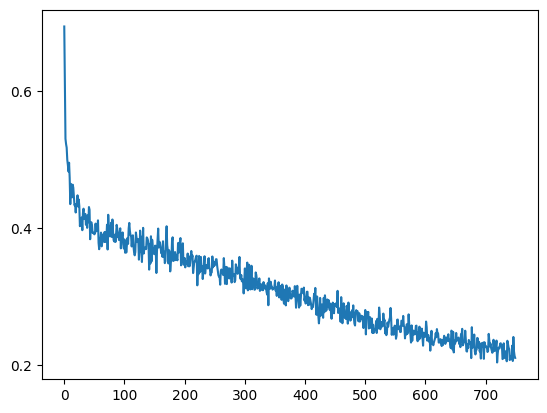

In [45]:
def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

showPlot(train_losses)

In [62]:
evaluateRandomly(model)

> 他是三个孩子的父亲 。
= he is the father of three children .
< he is a good at the . . <EOS>

> 我们快要结束了 。
= we re just about finished here .
< we re having to go . <EOS>

> 她将生孩子 。
= she is going to have a baby .
< she is good at the now . <EOS>

> 他是美国人 。
= he is american .
< he is an . <EOS>

> 他们自给自足 。
= they re self sufficient .
< they are having a . . <EOS>

> 他现在出去了 。
= he s out now .
< he s out now . <EOS>

> 你是我唯一能信任的人 。
= you re the only one i can trust .
< you re the to the the i . <EOS>

> 你们有大麻烦了 。
= you re in big trouble .
< you re too too . <EOS>

> 你够大了知道不要那样做 。
= you are old enough to know better than to act like that .
< you re not as young as you are . <EOS>

> 我站在汤姆一边 。
= i m on tom s side .
< i m going to the . . <EOS>



In [64]:
output_words = evaluate(model, '我是自由的')
output_sentence = ' '.join(output_words)
print(output_sentence)

i am a . <EOS>
